In [1]:
from util import *

# Example Notebook

This notebook shows how to load in a cleaned dataset with various features and target variables.

In [2]:
# Change to directory of dataset file
# Dataset file is guaranteed to have all days for all stocks, i.e. shift(30) is guaranteed to be 30 calendar days
# This leaves a lot of NaNs to be filled
path = "~/s3local/sentimentgroup/datasets/roberta.parquet"

In [3]:
# Horizons to calculate future returns (e.g. price after N days)
target_horizons = [10, 30, 90]
# Horizons to calculate lookbacks for rolling means (e.g. mean sentiment over last N days)
lookback_periods = [10, 30, 90]
# Enable to add residualised returns as a target 
# Also known as idiosyncratic returns, ie individual stock returns after removing overall market trends 
# Takes about 60 seconds per target horizon, so disable if not needed
residualise_returns = False

# Date range, leave None to use all available data (where we have prices)
start_date = "2014-01-01"
end_date = "2022-01-01" # Keep out of sample for now
df = load_dataset(
    path,
    target_horizons = target_horizons,
    lookback_periods = lookback_periods,
    residualise_returns = residualise_returns,
    start_date=start_date,
    end_date=end_date
)

                dt symbol  news_sentiment  submissions_sentiment  \
3653    2014-01-01   CBRE             NaN                    NaN   
3654    2014-01-02   CBRE             NaN                    NaN   
3655    2014-01-03   CBRE             NaN                    NaN   
3656    2014-01-04   CBRE             NaN                    NaN   
3657    2014-01-05   CBRE             NaN                    NaN   
...            ...    ...             ...                    ...   
3834899 2021-12-28    UAL             NaN                    NaN   
3834900 2021-12-29    UAL       -0.595749                    NaN   
3834901 2021-12-30    UAL             NaN              -0.063736   
3834902 2021-12-31    UAL             NaN                    NaN   
3834903 2022-01-01    UAL             NaN                    NaN   

         comments_sentiment    open  close   high     low  sp500_open  \
3653                    NaN     NaN    NaN    NaN     NaN         NaN   
3654                    NaN     NaN  

100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


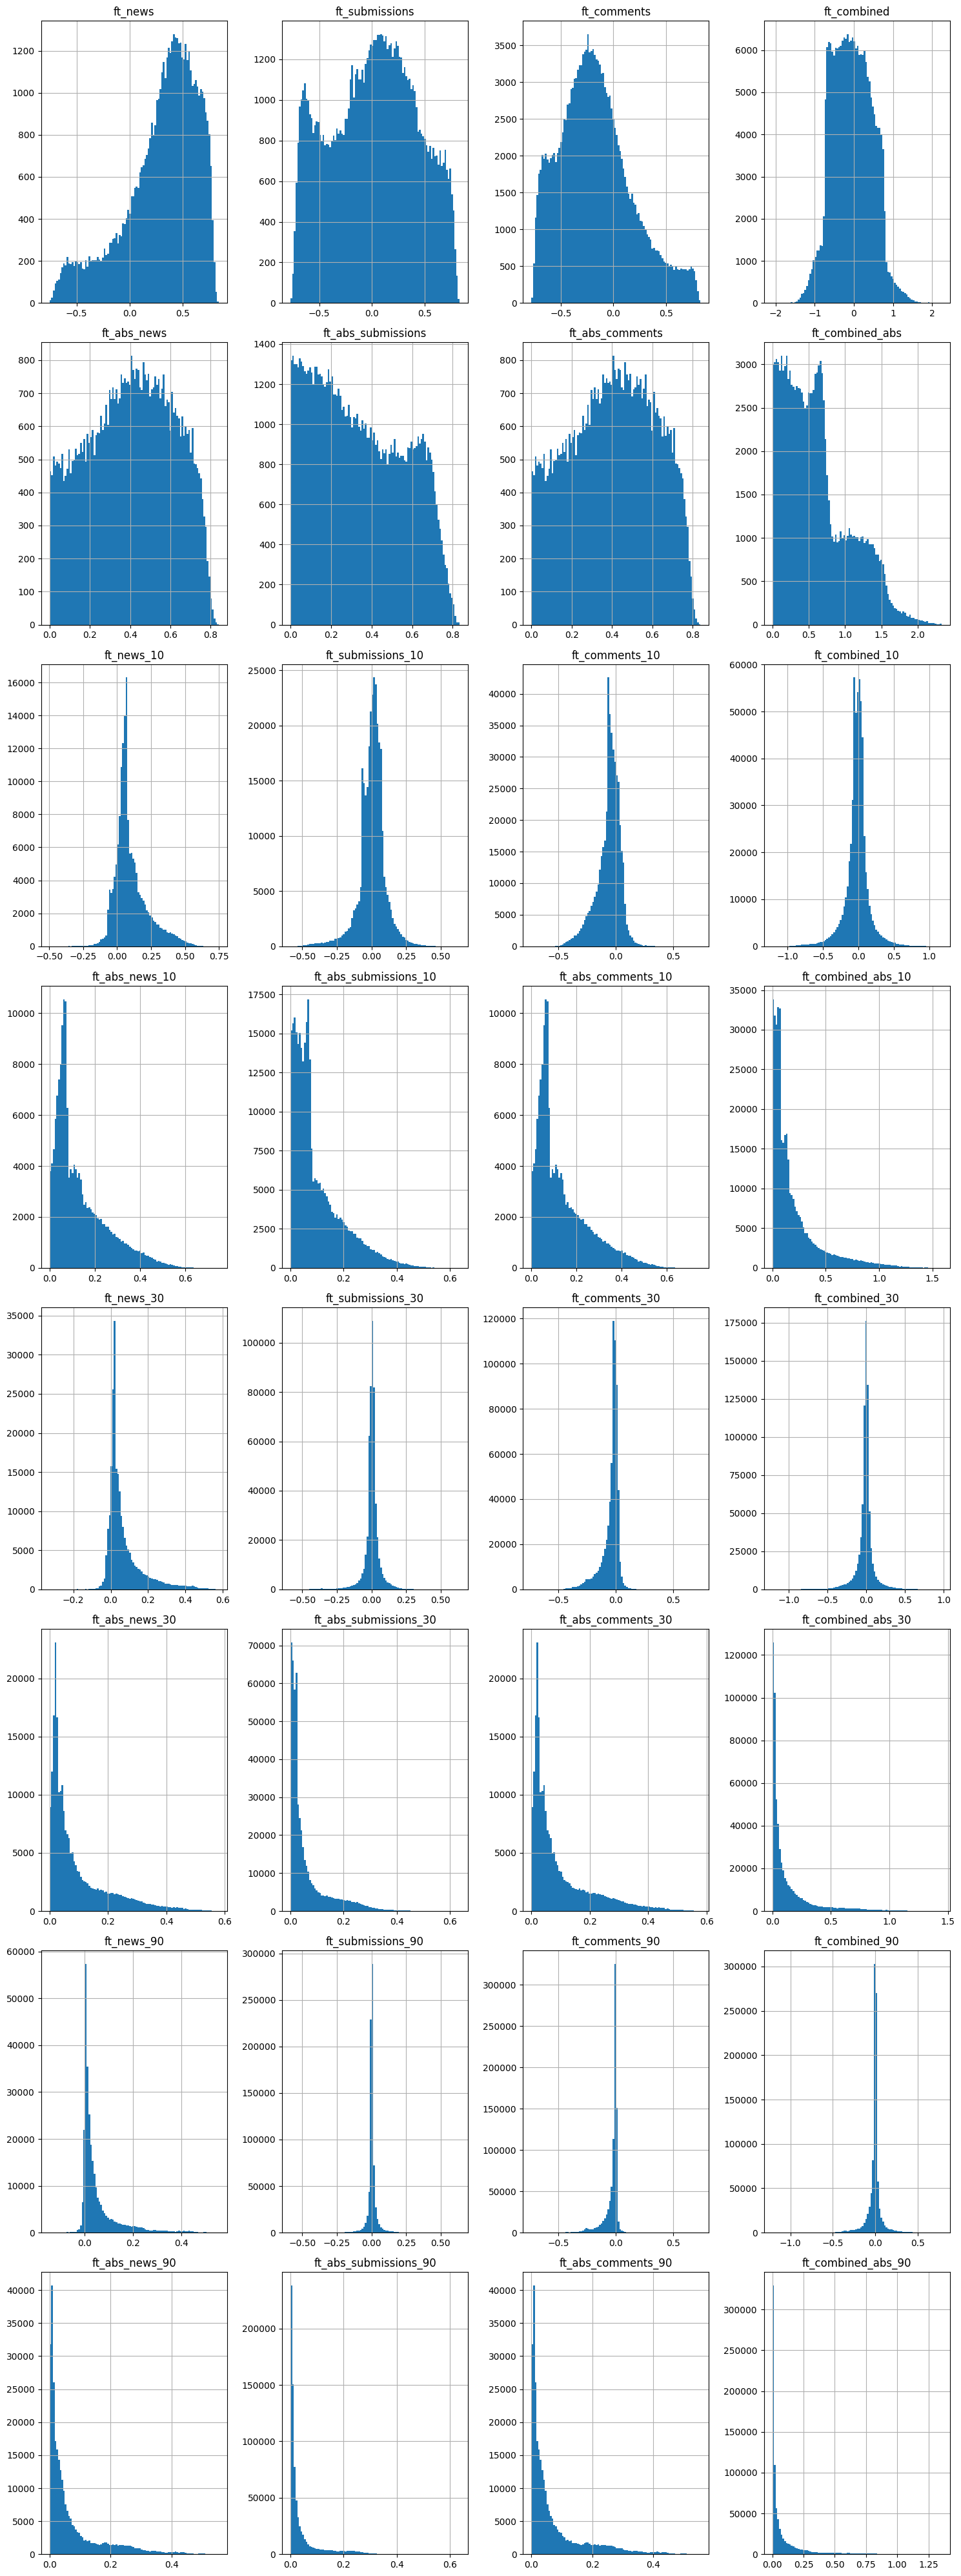

In [4]:

# Select feature columns
fts = [c for c in df.columns if c.startswith("ft_")]

# Plot in a grid
ncols = 4  # Number of columns in the grid
nrows = int(np.ceil(len(fts) / ncols))  # Compute rows dynamically
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))

# Flatten axes in case it's a multi-dimensional array
axes = axes.flatten()

# Plot each feature
for i, c in enumerate(fts):
    df[df[c] != 0][c].hist(bins=100, ax=axes[i])
    axes[i].set_title(c)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [5]:
# Some well known stocks
popular_symbols = [
    "AAPL", "MSFT", "TSLA", "AMZN", "NVDA", "NFLX", 
    "META", "IBM", "MCD", "NKE", "SBUX", "MS", "JPM",
    "EBAY", "COST", "GE", "BA", "PYPL", "GS", 
]

In [16]:
popular = df[df.symbol.isin(popular_symbols)].copy()

In [7]:
# Helper function for Cumsum(target) vs Feature plot (also in util.py)
def csvf_plot(df, ft, tgt):
    cs = df.sort_values(ft)
    cs["cs_ret"] = cs[tgt].cumsum()
    cs["cs_trades"] = 1
    cs["cs_trades"] = cs.cs_trades.cumsum()
    ax = cs.plot(x=ft, y="cs_ret")
    cs.plot(x=ft, y="cs_trades", ax=ax.twinx(), style='r--')

Here are some example csvf plots to show the usage

Forward returns (10 day) vs mean submission sentiment in last 10 days.
If there were no correlation at all, the blue line would lie exactly on top of the red dotted line.
In the bottom left we can see (-0.4 to -0.2) that the target cumsum is below cs_trades - this shows that the average returns at lower sentiment were smaller, and at the top right (sentiment 0.1 to 0.2) we see that the blue line crossed above the red line, indicating that returns there were larger.

Csvf plots aren't super sciencey, think of it as a sum of returns (i.e pnl) vs our feature. If we can find regions in the X axis where pnl goes up a lot, we should buy, if it goes down a lot, we want to sell. The fact these two lines are very similar shows how small correlations are, this isn't discouraging, if we could see huge differences it would suggest something was wrong.

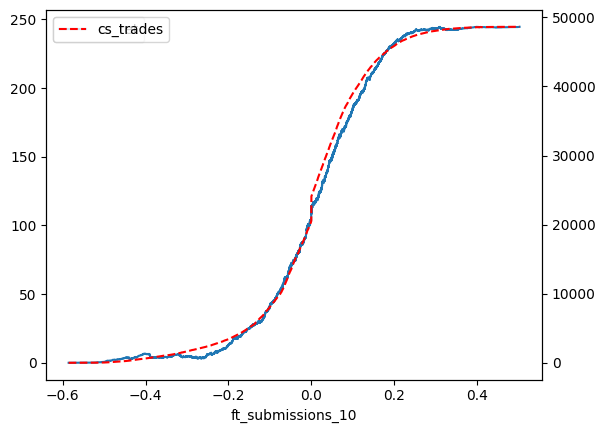

In [17]:
csvf_plot(popular, "ft_submissions_10", "tgt_forward_returns_10")

Forward returns versus news - Bit weirder this one due to the bias present in news sentiment, but since the cumsum gradient above sentiment 0.1 is greater than the red dotted line gradient (i.e it's catching up), and the red dotted line at zero is much higher than the combined news, this implies a good chunk of returns were to be had when there were (probably positive) news stories about the companies.

I.e. in the zone sentiment > 0.1 if we bought £1 of each stock on each day and held each dollar for 30 days we made ~240-160= 80 "units" of return from trades on ~48000-40000=8000 days, (or 0.01 avg) which means (e^0.01)*£1 = 1p over 30 days on average from £1 bought.

In comparison, at and below 0 sentiment, we made ~120 units of return over ~32000 = ~30000 days or 0.0038 avg, so a 0.38p gain over the next 30 days on average per £1 bought. This is all before fees/impact/spread costs, but suggests roughly 2-3x gains during periods with recent good news vs no new or negative news.

(This is rough and in sample)

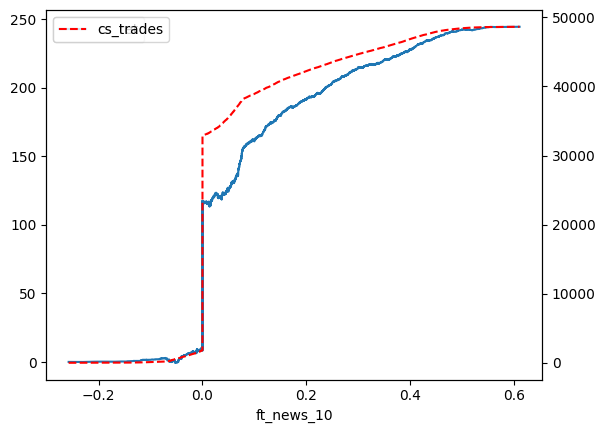

In [29]:
csvf_plot(popular, "ft_news_10", "tgt_forward_returns_10")

Calculating pearson coefficient for the above data:

In [31]:
pearsonr(popular["ft_news_10"], popular["tgt_forward_returns_10"])

PearsonRResult(statistic=0.03377316298719697, pvalue=9.303745992600873e-14)

Adjusted pearsonr (every 10 days roughly) shows a 1% p value.

In [32]:
downsample = popular[::10]
pearsonr(downsample["ft_news_10"], downsample["tgt_forward_returns_10"])

PearsonRResult(statistic=0.03663892026063058, pvalue=0.010603937346822382)

This maybe due to survivorship bias, but we can test out of sample.